[CNN] Epoch 1 finished
[CNN-VAL] Accuracy: 98.23%
[CNN] Epoch 2 finished
[CNN-VAL] Accuracy: 98.40%
[Extract] train: torch.Size([54000, 128])
[Extract] val: torch.Size([6000, 128])
[Extract] test: torch.Size([10000, 128])

PCA
PCA reduced to 4 dims, variance explained 0.619
[PCA-MLP] Epoch 1 Batch 0 Loss: 10.841138
[PCA-MLP] Epoch 1 Batch 100 Loss: 0.477197
[PCA-MLP] Epoch 1 Batch 200 Loss: 0.223278
[PCA-MLP] Epoch 1 Batch 300 Loss: 0.240077
[PCA-MLP] Epoch 1 Batch 400 Loss: 0.364747
[PCA-MLP] Epoch 1 Batch 500 Loss: 0.355442
[PCA-MLP] Epoch 1 Batch 600 Loss: 0.330353
[PCA-MLP] Epoch 1 Batch 700 Loss: 0.303242
[PCA-MLP] Epoch 1 Batch 800 Loss: 0.292160
[PCA-MLP] Epoch 1 Avg Loss: 0.487341
[PCA-MLP-VAL] Accuracy: 89.12%
[PCA-MLP-TEST] Accuracy: 90.74%
[PCA-MLP] Epoch 2 Batch 0 Loss: 0.209938
[PCA-MLP] Epoch 2 Batch 100 Loss: 0.287678
[PCA-MLP] Epoch 2 Batch 200 Loss: 0.275453
[PCA-MLP] Epoch 2 Batch 300 Loss: 0.167979
[PCA-MLP] Epoch 2 Batch 400 Loss: 0.210411
[PCA-MLP] Epoch 2 Batch 50

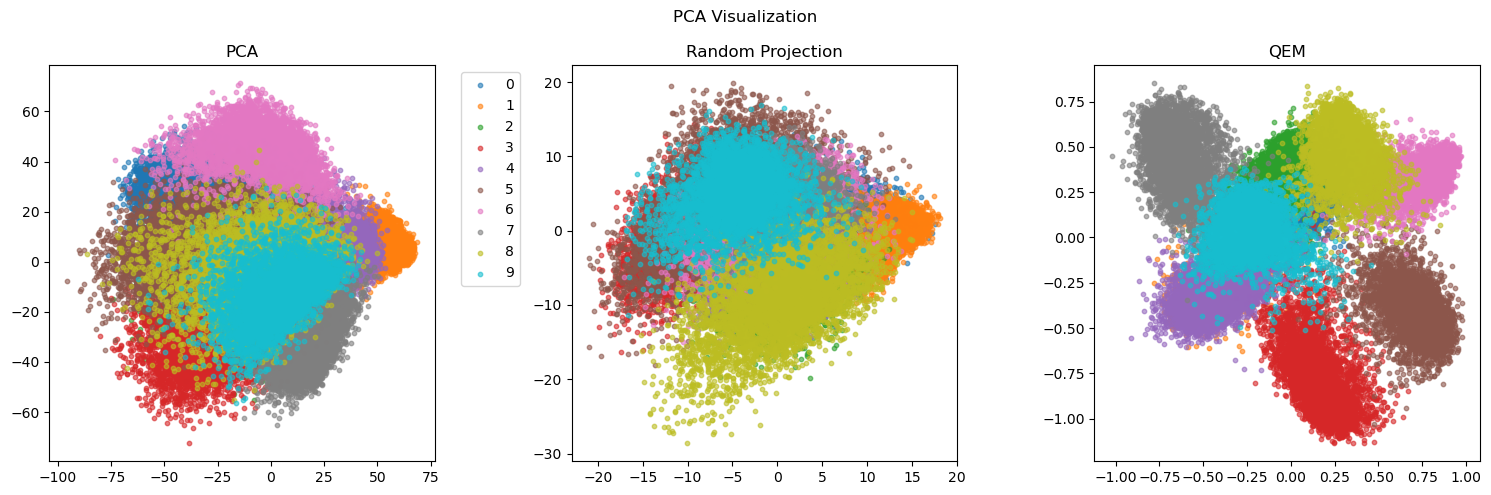

t-SNE Visualization...


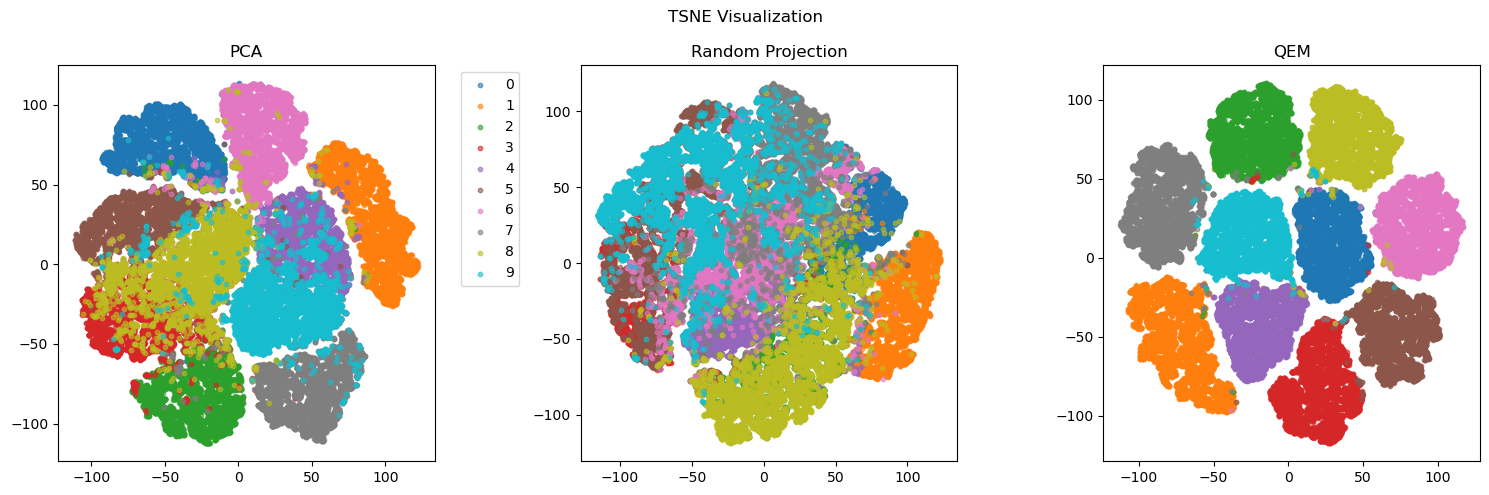

In [1]:
#Linear Layer (128,16) => 4qubit + MLP 실험 (이 때 앞쪽 Linear 내의 parameter 업데이트 되는지도 확인)
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import datetime 

# ========== Config ==========
class Config:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DATA_PATH = "./data"
    BATCH_SIZE = 64
    TEST_BATCH_SIZE = 1000
    CNN_HIDDEN_DIM = 128
    PROJECTION_DIM = 4      
    MLP_HIDDEN_DIM = 64
    NUM_CLASSES = 10
    LEARNING_RATE = 0.001
    CNN_EPOCHS = 2
    MLP_EPOCHS = 5
    LOG_INTERVAL = 100
    RANDOM_SEED = 42
    VAL_RATIO = 0.1
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    os.makedirs("./grad", exist_ok=True)
    os.makedirs("./checkp", exist_ok=True)
    pqc_grad_csv = f"./grad/pqc_grads_{timestamp}.csv"  
    prefc_grad_csv=f"./grad/prefc_grads_{timestamp}.csv"
    checkpoint_path=f"./checkp/checkpoint_{timestamp}.pt"

# ========== Models ==========
class CNN(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_features=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        x = F.relu(features)
        out = self.fc2(x)
        if return_features:
            return out, features
        return out

    def extract_features(self, x):
        _, features = self.forward(x, return_features=True)
        return features

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

# ========== Data ==========
def get_mnist_loaders(config):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_train = datasets.MNIST(config.DATA_PATH, train=True, download=True, transform=transform)
    test_ds = datasets.MNIST(config.DATA_PATH, train=False, download=True, transform=transform)
    val_size = int(len(full_train) * config.VAL_RATIO)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config.TEST_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=config.TEST_BATCH_SIZE, shuffle=False)
    return train_loader, val_loader, test_loader



# ========== Classical DR ==========
def extract_hidden_representations(model, dataloader, device, name="set"):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device); target = target.to(device)
            f = model.extract_features(data)
            feats.append(f.cpu()); labels.append(target.cpu())
    feats = torch.cat(feats); labels = torch.cat(labels)
    print(f"[Extract] {name}: {feats.shape}")
    return feats, labels

def apply_pca(train_f, val_f, test_f, n_components=Config.PROJECTION_DIM):
    pca = PCA(n_components=n_components)
    train_p = pca.fit_transform(train_f.numpy())
    val_p = pca.transform(val_f.numpy())
    test_p = pca.transform(test_f.numpy())
    print(f"PCA reduced to {n_components} dims, variance explained {pca.explained_variance_ratio_.sum():.3f}")
    return (torch.tensor(train_p, dtype=torch.float32),
            torch.tensor(val_p, dtype=torch.float32),
            torch.tensor(test_p, dtype=torch.float32))

def apply_random_projection(train_f, val_f, test_f, target_dim=Config.PROJECTION_DIM):
    in_dim = train_f.shape[1]
    P = torch.randn(in_dim, target_dim)
    P = P / torch.norm(P, dim=0, keepdim=True)
    train_p = train_f @ P
    val_p = val_f @ P
    test_p = test_f @ P
    print(f"Random Projection: {in_dim} → {target_dim}")
    return train_p, val_p, test_p

n_qubits = Config.PROJECTION_DIM    
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(inputs, weights):
    # x_cpu: (2^n) 1D torch vector on CPU, requires_grad ok
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # Pennylane(torch) returns torch tensor (float64) by default
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumEmbeddingLayer(nn.Module):
    def __init__(self, n_qubits=Config.PROJECTION_DIM, n_features=128, n_layers=1):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.embed_dim = 2 ** n_qubits
        # Map input features -> 2^n amplitude vector 
        self.pre_fc = nn.Linear(n_features, self.embed_dim)
        # PQC parameters 
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, dtype=torch.float32) * 0.01)
        weight_shapes = {"weights": (n_layers, n_qubits)}
        self.q_embeddinglayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        vec = self.pre_fc(x)
        # 배치 전체를 양자 레이어에 전달 (GPU 사용)
        #print("vec",vec.shape)
        q_res = self.q_embeddinglayer(vec)
        # 반환 크기: (B, n_qubits)
        return q_res.float()

class QEBNet(nn.Module):
    def __init__(self, n_qubits=Config.PROJECTION_DIM, n_features=128, hidden_dim=64, num_classes=10, n_layers=1):
        super().__init__()
        self.q_layer = QuantumEmbeddingLayer(n_qubits, n_features, n_layers)
        self.mlp = MLP(n_qubits, hidden_dim, num_classes)
    def forward(self, x):
        q = self.q_layer(x)
        return self.mlp(q)
# ========== CSV (PQC grad 전용) ==========
def init_grad_csv(path, header):
    if os.path.exists(path):
        os.remove(path)
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["epoch"] + header)

def append_grad_csv(path, epoch, grad_tensor):
    g = grad_tensor.detach().cpu().reshape(-1).tolist()
    with open(path, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([epoch] + g)

# ========== Train / Eval ==========
def evaluate_model(model, dataloader, device, prefix=""):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100. * correct / len(dataloader.dataset)
    print(f"{prefix} Accuracy: {acc:.2f}%")
    return acc

def train_cnn(model, train_loader, val_loader, config):
    opt = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    for epoch in range(config.CNN_EPOCHS):
        model.train()
        for data, target in train_loader:
            data, target = data.to(config.DEVICE), target.to(config.DEVICE)
            opt.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, target)
            loss.backward()
            opt.step()
        print(f"[CNN] Epoch {epoch+1} finished")
        evaluate_model(model, val_loader, config.DEVICE, "[CNN-VAL]")
    return model

def train_mlp(model, train_feats, train_labels, val_feats, val_labels, test_feats, test_labels, config, name="MLP", epochs=5):
    train_loader, val_loader, test_loader = make_loaders(train_feats, train_labels, val_feats, val_labels, test_feats, test_labels, config)


    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(config.DEVICE), target.to(config.DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % config.LOG_INTERVAL == 0:
                print(f"[{name}] Epoch {epoch} Batch {batch_idx} Loss: {loss.item():.6f}")

        avg_loss = total_loss / len(train_loader)
        print(f"[{name}] Epoch {epoch} Avg Loss: {avg_loss:.6f}")

        # validation / test
        evaluate_model(model, val_loader, config.DEVICE, f"[{name}-VAL]")
        evaluate_model(model, test_loader, config.DEVICE, f"[{name}-TEST]")

def train_qeb(
    model,
    train_feats, train_labels,
    val_feats, val_labels,
    test_feats, test_labels,
    config,
    name="QEB",
    epochs=30,
    grad_csv=Config.pqc_grad_csv,
    prefc_csv=Config.prefc_grad_csv,
    checkpoint_path="checkpoint.pt",
    resume=True
):
    """Quantum Embedding + MLP 학습 함수 (체크포인트 저장/로드 지원)"""

    # --- CSV 초기화 ---
    init_grad_csv(grad_csv,
                  [f"pqc_l{l}_q{i}" for l in range(model.q_layer.n_layers) for i in range(model.q_layer.n_qubits)])
    init_grad_csv(prefc_csv,
                  [f"pre_fc_w{i}" for i in range(model.q_layer.pre_fc.weight.numel())] +
                  [f"pre_fc_b{i}" for i in range(model.q_layer.pre_fc.bias.numel())])

    train_loader, val_loader, test_loader = make_loaders(train_feats, train_labels, val_feats, val_labels, test_feats, test_labels, config)

    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    start_epoch, step = 1, 0

    # --- 체크포인트 로드 ---
    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        step = checkpoint.get("step", 0)
        print(f"[{name}] Resumed from epoch {checkpoint['epoch']} (step {step})")

    # --- 학습 루프 ---
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(config.DEVICE), target.to(config.DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()

            # 🔹 1. PQC grad 기록 (수정!)
            pqc_weights = model.q_layer.q_embeddinglayer.weights
            if pqc_weights.grad is not None:
                append_grad_csv(grad_csv, step, pqc_weights.grad)
            
            # 🔹 2. FC layer grad 기록 (추가!)
            fc_weight_grad = model.q_layer.pre_fc.weight.grad
            fc_bias_grad = model.q_layer.pre_fc.bias.grad
            
            if fc_weight_grad is not None and fc_bias_grad is not None:
                # weight와 bias를 flatten해서 합치기
                fc_grad_combined = torch.cat([
                    fc_weight_grad.reshape(-1),
                    fc_bias_grad.reshape(-1)
                ])
                append_grad_csv(prefc_csv, step, fc_grad_combined)

            optimizer.step()
            total_loss += loss.item()

            if batch_idx % config.LOG_INTERVAL == 0:
                print(f"[{name}] Epoch {epoch} Batch {batch_idx} Loss: {loss.item():.6f}")

            step += 1

        avg_loss = total_loss / len(train_loader)
        print(f"[{name}] Epoch {epoch} Avg Loss: {avg_loss:.6f}")

        # validation / test
        evaluate_model(model, val_loader, config.DEVICE, f"[{name}-VAL]")
        evaluate_model(model, test_loader, config.DEVICE, f"[{name}-TEST]")

        # --- 체크포인트 저장 ---
        torch.save({
            "epoch": epoch,
            "step": step,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, f"./checkp/qeb_checkpoint_{epoch}.pt")
        print(f"[{name}] Checkpoint saved at epoch {epoch}")

    print(f"\n[CSV] PQC gradients saved to: {grad_csv}")
    print(f"[CSV] FC gradients saved to: {prefc_csv}")
    
    return model

def extract_quantum_embeddings(qeb_model, dataloader, device):
    """QEB 모델에서 quantum embedding 결과 추출"""
    qeb_model.eval()
    embeddings, labels = [], []
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            q_embedding = qeb_model.q_layer(data)
            embeddings.append(q_embedding.cpu())
            labels.append(target.cpu())
    
    return torch.cat(embeddings), torch.cat(labels)

def visualize_embeddings(pca_emb, rp_emb, qem_emb, labels, method='PCA'):
    """3개 임베딩을 2D로 시각화"""
    
    embeddings = {'PCA': pca_emb, 'Random Projection': rp_emb, 'QEM': qem_emb}
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = plt.cm.tab10(np.arange(10))
    
    for idx, (name, emb) in enumerate(embeddings.items()):
        # 2D 변환
        if method == 'PCA':
            reducer = PCA(n_components=2, random_state=42)
        else:  # t-SNE
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        
        emb_2d = reducer.fit_transform(emb.numpy())
        
        # 시각화
        ax = axes[idx]
        for digit in range(10):
            mask = labels.numpy() == digit
            if mask.sum() > 0:
                ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                          c=[colors[digit]], label=str(digit), 
                          alpha=0.6, s=10)
        
        ax.set_title(f'{name}')
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle(f'{method} Visualization')
    plt.tight_layout()
    plt.show()

def make_loaders(train_feats, train_labels, val_feats, val_labels, test_feats, test_labels, config):
    """train/val/test 텐서에서 DataLoader 3개 생성"""
    train_dataset = TensorDataset(train_feats, train_labels)
    val_dataset = TensorDataset(val_feats, val_labels)
    test_dataset = TensorDataset(test_feats, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader
    
config = Config()
torch.manual_seed(config.RANDOM_SEED)
torch.cuda.manual_seed_all(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_loader, val_loader, test_loader = get_mnist_loaders(config)
# 1) CNN 학습
cnn = CNN(config.CNN_HIDDEN_DIM, config.NUM_CLASSES).to(config.DEVICE)
cnn = train_cnn(cnn, train_loader, val_loader, config)

# 2) CNN feature 추출
train_f, train_y = extract_hidden_representations(cnn, train_loader, config.DEVICE, "train")
val_f, val_y = extract_hidden_representations(cnn, val_loader, config.DEVICE, "val")
test_f, test_y = extract_hidden_representations(cnn, test_loader, config.DEVICE, "test")

# 3) PCA baseline
print("\n" + "="*50); print("PCA"); print("="*50)
train_p, val_p, test_p = apply_pca(train_f, val_f, test_f, config.PROJECTION_DIM)
pca_mlp = MLP(train_p.shape[1], config.MLP_HIDDEN_DIM, config.NUM_CLASSES).to(config.DEVICE)
train_mlp(pca_mlp, train_p, train_y, val_p, val_y, test_p, test_y, config, "PCA-MLP")

# 4) RP baseline
print("\n" + "="*50); print("Random Projection"); print("="*50)
train_rp, val_rp, test_rp = apply_random_projection(train_f, val_f, test_f, config.PROJECTION_DIM)
rp_mlp = MLP(train_rp.shape[1], config.MLP_HIDDEN_DIM, config.NUM_CLASSES).to(config.DEVICE)
train_mlp(rp_mlp, train_rp, train_y, val_rp, val_y, test_rp, test_y, config, "RP-MLP")

# 5) QEB(PQC) end-to-end on features
print("\n" + "="*50); print("QEB + MLP (End-to-End on features)"); print("="*50)
qeb_model = QEBNet(
    n_qubits=config.PROJECTION_DIM,
    n_features=train_f.shape[1],
    hidden_dim=config.MLP_HIDDEN_DIM,
    num_classes=config.NUM_CLASSES,
    n_layers=1
).to(config.DEVICE)
# train_mlp와 동일하게 test 데이터도 전달
train_qeb(qeb_model, train_f, train_y, val_f, val_y, test_f, test_y, config, "QEB-MLP", epochs=30, grad_csv=Config.pqc_grad_csv)


print("\n" + "="*50)
print("Embedding Visualization")  
print("="*50)
    
# QEB에서 quantum embedding 추출
train_dataset = torch.utils.data.TensorDataset(train_f, train_y)
train_loader_viz = torch.utils.data.DataLoader(train_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=False)
    
qem_embeddings, qem_labels = extract_quantum_embeddings(qeb_model, train_loader_viz, config.DEVICE)
    
# PCA 시각화
print("PCA Visualization...")
visualize_embeddings(train_p, train_rp, qem_embeddings, train_y, method='PCA')
    
# t-SNE 시각화  
print("t-SNE Visualization...")
visualize_embeddings(train_p, train_rp, qem_embeddings, train_y, method='TSNE')